In [1]:
import numpy as np
import pandas as pd
import dask.dataframe as dd
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import display
from scipy import stats
from statistics import stdev
import datetime
from datetime import timedelta
from collections import Counter
#import cx_Oracle
import psycopg2
import seaborn as sns
import json
import pickle
#from fitter import Fitter
from warnings import filterwarnings
filterwarnings('ignore')

In [2]:
data = pd.read_pickle("./pl_sp_orders_from_tiers_51-56.pkl")

In [3]:
data.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4122380 entries, 0 to 4169236
Data columns (total 26 columns):
SCM_N_ORDER_POS_NR              int64
SCM_N_ORDER_NR                  int64
TDT_T_KEY_ORDER_DATE            datetime64[ns]
THR_C_KEY_ORDER_HOUR            object
SIT_N_KEY_SITE                  int64
CUS_N_KEY_CUSTOMER              int64
SCM_SALES_BMF                   float64
SCM_D_FINANCE_CM1               float64
SCM_D_FINANCE_CM2               float64
SCM_D_ORIG_FINANCE_ORDER_NET    float64
SCM_AP_ID                       int64
SCM_AS_ID                       int64
SCM_MASTER_AP_ID                int64
OSP_KO_COUNT_NET                int64
OSP_3_LEAD_P_PG_ID              int64
OSP_3_LEAD_P_PG_SHARE           float64
OSP_4_LEAD_P_PG_ID              int64
OSP_4_LEAD_P_PG_SHARE           float64
CZP_START_DATE                  datetime64[ns]
CZP_EXPIRY_DATE                 datetime64[ns]
CZP_ZTQ_ID                      int64
CZP_PERCENTAGE                  int64
CZP_PRICE  

In [4]:
data.head()

,SCM_N_ORDER_POS_NR,SCM_N_ORDER_NR,TDT_T_KEY_ORDER_DATE,THR_C_KEY_ORDER_HOUR,SIT_N_KEY_SITE,CUS_N_KEY_CUSTOMER,SCM_SALES_BMF,SCM_D_FINANCE_CM1,SCM_D_FINANCE_CM2,SCM_D_ORIG_FINANCE_ORDER_NET,...,OSP_4_LEAD_P_PG_ID,OSP_4_LEAD_P_PG_SHARE,CZP_START_DATE,CZP_EXPIRY_DATE,CZP_ZTQ_ID,CZP_PERCENTAGE,CZP_PRICE,ORDER_DATETIME,WEEK_NUMBER,MONTH_NUMBER
0,407413245,95485222,2017-10-01,22:23,8,7968806,0.0000,-0.1610,-0.3397,0.0000,...,35032,0.3962,2015-09-20 14:32:00,2018-09-20 23:59:00,52,3,4.95,2017-10-01 22:23:00,39,10
1,407413245,95485222,2017-10-01,22:23,8,7968806,0.0000,-0.1580,-0.3333,0.0000,...,35032,0.3962,2015-09-20 14:32:00,2018-09-20 23:59:00,52,3,4.95,2017-10-01 22:23:00,39,10
2,407411390,95484882,2017-10-01,22:17,8,17900077,-0.5818,-0.5387,-0.5387,-0.5387,...,74051,1.0000,2017-09-12 21:47:00,2018-09-12 23:59:00,55,2,1.95,2017-10-01 22:17:00,39,10
3,407406910,95483668,2017-10-01,22:02,8,11917177,4.6449,1.2764,-0.7351,3.7764,...,218624,0.5307,2017-07-06 13:10:00,2018-07-06 23:59:00,51,3,2.45,2017-10-01 22:02:00,39,10
4,407210303,95437363,2017-10-01,11:48,8,15533036,9.2899,1.1217,0.3855,8.6017,...,18245,0.3833,2017-01-31 14:03:00,2018-01-31 23:59:00,56,4,3.20,2017-10-01 11:48:00,39,10


In [5]:
data['FIRST_O_DATE'] = data['TDT_T_KEY_ORDER_DATE'].groupby(data['CUS_N_KEY_CUSTOMER']).transform('min')

In [6]:
data['LAST_O_DATE'] = data['TDT_T_KEY_ORDER_DATE'].groupby(data['CUS_N_KEY_CUSTOMER']).transform('max')

In [7]:
data['1ST_O_COUNTER'] = data['OSP_KO_COUNT_NET'].groupby(data['CUS_N_KEY_CUSTOMER']).transform('min')

In [8]:
data['D28'] = data['FIRST_O_DATE'] + timedelta(days = 28)
data['D56'] = data['FIRST_O_DATE'] + timedelta(days = 56)
data['D84'] = data['FIRST_O_DATE'] + timedelta(days = 84)
data['D168'] = data['FIRST_O_DATE'] + timedelta(days = 168)
data['D252'] = data['FIRST_O_DATE'] + timedelta(days = 252)
data['D336'] = data['FIRST_O_DATE'] + timedelta(days = 336)

In [9]:
data.columns

Index(['SCM_N_ORDER_POS_NR', 'SCM_N_ORDER_NR', 'TDT_T_KEY_ORDER_DATE',
       'THR_C_KEY_ORDER_HOUR', 'SIT_N_KEY_SITE', 'CUS_N_KEY_CUSTOMER',
       'SCM_SALES_BMF', 'SCM_D_FINANCE_CM1', 'SCM_D_FINANCE_CM2',
       'SCM_D_ORIG_FINANCE_ORDER_NET', 'SCM_AP_ID', 'SCM_AS_ID',
       'SCM_MASTER_AP_ID', 'OSP_KO_COUNT_NET', 'OSP_3_LEAD_P_PG_ID',
       'OSP_3_LEAD_P_PG_SHARE', 'OSP_4_LEAD_P_PG_ID', 'OSP_4_LEAD_P_PG_SHARE',
       'CZP_START_DATE', 'CZP_EXPIRY_DATE', 'CZP_ZTQ_ID', 'CZP_PERCENTAGE',
       'CZP_PRICE', 'ORDER_DATETIME', 'WEEK_NUMBER', 'MONTH_NUMBER',
       'FIRST_O_DATE', 'LAST_O_DATE', '1ST_O_COUNTER', 'D28', 'D56', 'D84',
       'D168', 'D252', 'D336'],
      dtype='object')

In [10]:
agg_ops = {'TDT_T_KEY_ORDER_DATE': min,
          'CUS_N_KEY_CUSTOMER': min,
          'CZP_ZTQ_ID': min, 
          'SCM_SALES_BMF': sum,
          'SCM_D_FINANCE_CM1': sum,
          'SCM_D_FINANCE_CM2': sum,
          'SCM_D_ORIG_FINANCE_ORDER_NET': sum,
          'OSP_KO_COUNT_NET': min,
          'CZP_START_DATE': min,
          'CZP_EXPIRY_DATE': min,
          'ORDER_DATETIME': min,
          'FIRST_O_DATE': min,
          'LAST_O_DATE': min,
          '1ST_O_COUNTER': min,
          'D28': min,
          'D56': min,
          'D84': min,
          'D168': min,
          'D252': min,
          'D336': min
          }

In [11]:
orders = data.groupby('SCM_N_ORDER_NR', as_index=False).agg(agg_ops)

In [12]:
data['SCM_N_ORDER_NR'].nunique(), len(orders)

(642347, 642347)

In [13]:
orders.tail()

,SCM_N_ORDER_NR,TDT_T_KEY_ORDER_DATE,CUS_N_KEY_CUSTOMER,CZP_ZTQ_ID,SCM_SALES_BMF,SCM_D_FINANCE_CM1,SCM_D_FINANCE_CM2,SCM_D_ORIG_FINANCE_ORDER_NET,OSP_KO_COUNT_NET,CZP_START_DATE,...,ORDER_DATETIME,FIRST_O_DATE,LAST_O_DATE,1ST_O_COUNTER,D28,D56,D84,D168,D252,D336
642342,120154239,2018-09-30,20864482,51,27.2521,9.6761,6.0122,22.1561,6,2018-09-30 00:00:00,...,2018-09-30 23:55:00,2018-09-30,2018-09-30,6,2018-10-28,2018-11-25,2018-12-23,2019-03-17,2019-06-09,2019-09-01
642343,120154279,2018-09-30,9622728,53,147.5609,25.5866,16.6988,131.6166,82,2018-05-23 00:00:00,...,2018-09-30 23:57:00,2017-10-03,2018-09-30,48,2017-10-31,2017-11-28,2017-12-26,2018-03-20,2018-06-12,2018-09-04
642344,120154298,2018-09-30,6427183,53,150.5464,23.9224,13.8397,139.0723,24,2018-09-30 00:00:00,...,2018-09-30 23:58:00,2018-09-30,2018-09-30,24,2018-10-28,2018-11-25,2018-12-23,2019-03-17,2019-06-09,2019-09-01
642345,120154308,2018-09-30,15408875,53,32.1164,7.9075,4.4923,29.7375,37,2018-02-12 20:19:00,...,2018-09-30 23:58:00,2017-10-24,2018-09-30,17,2017-11-21,2017-12-19,2018-01-16,2018-04-10,2018-07-03,2018-09-25
642346,120154329,2018-09-30,17958111,54,35.5393,14.1615,11.1756,32.2815,15,2018-09-30 00:00:00,...,2018-09-30 23:59:00,2017-10-11,2018-09-30,3,2017-11-08,2017-12-06,2018-01-03,2018-03-28,2018-06-20,2018-09-12


In [14]:
orders['OK_28D'] = (orders['TDT_T_KEY_ORDER_DATE'] <= orders['D28']) * 1
orders['OK_56D'] = (orders['TDT_T_KEY_ORDER_DATE'] <= orders['D56']) * 1
orders['OK_84D'] = (orders['TDT_T_KEY_ORDER_DATE'] <= orders['D84']) * 1
orders['OK_168D'] = (orders['TDT_T_KEY_ORDER_DATE'] <= orders['D168']) * 1
orders['OK_252D'] = (orders['TDT_T_KEY_ORDER_DATE'] <= orders['D252']) * 1
orders['OK_336D'] = (orders['TDT_T_KEY_ORDER_DATE'] <= orders['D336']) * 1

In [15]:
orders['COUNTER_28D'] = orders['OK_28D'] * orders['OSP_KO_COUNT_NET']
orders['COUNTER_56D'] = orders['OK_56D'] * orders['OSP_KO_COUNT_NET']
orders['COUNTER_84D'] = orders['OK_84D'] * orders['OSP_KO_COUNT_NET']
orders['COUNTER_168D'] = orders['OK_168D'] * orders['OSP_KO_COUNT_NET']
orders['COUNTER_252D'] = orders['OK_252D'] * orders['OSP_KO_COUNT_NET']
orders['COUNTER_336D'] = orders['OK_336D'] * orders['OSP_KO_COUNT_NET']

In [16]:
orders['MAX_COUNTER_28D'] = orders['COUNTER_28D'].groupby(orders['CUS_N_KEY_CUSTOMER']).transform('max')
orders['MAX_COUNTER_56D'] = orders['COUNTER_56D'].groupby(orders['CUS_N_KEY_CUSTOMER']).transform('max')
orders['MAX_COUNTER_84D'] = orders['COUNTER_84D'].groupby(orders['CUS_N_KEY_CUSTOMER']).transform('max')
orders['MAX_COUNTER_168D'] = orders['COUNTER_168D'].groupby(orders['CUS_N_KEY_CUSTOMER']).transform('max')
orders['MAX_COUNTER_252D'] = orders['COUNTER_252D'].groupby(orders['CUS_N_KEY_CUSTOMER']).transform('max')
orders['MAX_COUNTER_336D'] = orders['COUNTER_336D'].groupby(orders['CUS_N_KEY_CUSTOMER']).transform('max')

In [17]:
orders['RR_28D'] = (orders['MAX_COUNTER_28D'] > orders['1ST_O_COUNTER']) * 1
orders['RR_56D'] = (orders['MAX_COUNTER_56D'] > orders['MAX_COUNTER_28D']) * 1
orders['RR_84D'] = (orders['MAX_COUNTER_84D'] > orders['MAX_COUNTER_56D']) * 1 
orders['RR_168D'] = (orders['MAX_COUNTER_168D'] > orders['MAX_COUNTER_84D']) * 1
orders['RR_252D'] = (orders['MAX_COUNTER_252D'] > orders['MAX_COUNTER_168D']) * 1 
orders['RR_336D'] = (orders['MAX_COUNTER_336D'] > orders['MAX_COUNTER_168D']) * 1

In [18]:
orders.columns

Index(['SCM_N_ORDER_NR', 'TDT_T_KEY_ORDER_DATE', 'CUS_N_KEY_CUSTOMER',
       'CZP_ZTQ_ID', 'SCM_SALES_BMF', 'SCM_D_FINANCE_CM1', 'SCM_D_FINANCE_CM2',
       'SCM_D_ORIG_FINANCE_ORDER_NET', 'OSP_KO_COUNT_NET', 'CZP_START_DATE',
       'CZP_EXPIRY_DATE', 'ORDER_DATETIME', 'FIRST_O_DATE', 'LAST_O_DATE',
       '1ST_O_COUNTER', 'D28', 'D56', 'D84', 'D168', 'D252', 'D336', 'OK_28D',
       'OK_56D', 'OK_84D', 'OK_168D', 'OK_252D', 'OK_336D', 'COUNTER_28D',
       'COUNTER_56D', 'COUNTER_84D', 'COUNTER_168D', 'COUNTER_252D',
       'COUNTER_336D', 'MAX_COUNTER_28D', 'MAX_COUNTER_56D', 'MAX_COUNTER_84D',
       'MAX_COUNTER_168D', 'MAX_COUNTER_252D', 'MAX_COUNTER_336D', 'RR_28D',
       'RR_56D', 'RR_84D', 'RR_168D', 'RR_252D', 'RR_336D'],
      dtype='object')

In [19]:
agg_ord_ops = {'CZP_ZTQ_ID': 'unique',
              'SCM_N_ORDER_NR': len,
              'SCM_SALES_BMF': [sum, lambda x: list(np.round(x, 2))],
              'SCM_D_FINANCE_CM1': [sum, lambda x: list(np.round(x, 2))],
              'SCM_D_FINANCE_CM2': [sum, lambda x: list(np.round(x, 2))],
              'SCM_D_ORIG_FINANCE_ORDER_NET': [sum, lambda x: list(np.round(x, 2))],
              'OSP_KO_COUNT_NET': lambda x: list(x),
              'CZP_START_DATE': 'unique',
              'CZP_EXPIRY_DATE': 'unique',
              'FIRST_O_DATE': min,
              'LAST_O_DATE': min,
              '1ST_O_COUNTER': min,
              'COUNTER_28D': max,
              'COUNTER_56D': max,
              'COUNTER_84D': max,
              'COUNTER_168D': max,
              'COUNTER_252D': max,
              'COUNTER_336D': max
              }

In [20]:
customers = orders.groupby('CUS_N_KEY_CUSTOMER', as_index=False).agg(agg_ord_ops).round(2)

In [21]:
customers.columns = ['_'.join(tup).rstrip('_') for tup in customers.columns.values]

In [22]:
customers.head()

,CUS_N_KEY_CUSTOMER,CZP_ZTQ_ID_unique,SCM_N_ORDER_NR_len,SCM_SALES_BMF_sum,SCM_SALES_BMF_<lambda>,SCM_D_FINANCE_CM1_sum,SCM_D_FINANCE_CM1_<lambda>,SCM_D_FINANCE_CM2_sum,SCM_D_FINANCE_CM2_<lambda>,SCM_D_ORIG_FINANCE_ORDER_NET_sum,...,CZP_EXPIRY_DATE_unique,FIRST_O_DATE_min,LAST_O_DATE_min,1ST_O_COUNTER_min,COUNTER_28D_max,COUNTER_56D_max,COUNTER_84D_max,COUNTER_168D_max,COUNTER_252D_max,COUNTER_336D_max
0,386699,[52],1,24.70,[24.7],3.28,[3.28],0.09,[0.09],22.87,...,[2020-11-02T23:59:00.000000000],2018-05-25,2018-05-25,157,157,157,157,157,157,157
1,611326,[53],9,482.27,"[77.82, 22.55, 37.84, 59.75, 25.13, 62.03, 26....",79.42,"[13.92, 2.65, 0.6, 17.16, 8.19, 8.67, 3.95, 16...",33.46,"[7.49, -1.07, -2.39, 9.16, 4.45, 1.57, 0.18, 9...",426.58,...,[2018-10-03T23:59:00.000000000],2017-10-03,2018-08-16,38,38,38,39,42,45,46
2,641200,[51],8,417.25,"[57.93, 36.72, 55.03, 73.64, 45.43, 46.81, 68....",49.43,"[11.8, 5.74, 9.2, 12.75, 5.9, 1.43, 0.51, 2.11]",21.28,"[9.09, -0.22, 5.14, 8.38, 3.04, -1.44, -2.35, ...",381.93,...,[2019-01-06T23:59:00.000000000],2018-01-06,2018-08-03,89,90,90,91,95,96,96
3,669369,[53],7,417.24,"[74.72, 37.57, 37.93, 37.52, 75.31, 75.54, 78.64]",48.62,"[7.19, 3.79, 4.1, 3.72, 9.53, 9.91, 10.38]",8.42,"[-0.11, 0.14, 1.02, 0.64, 1.74, 2.11, 2.87]",386.02,...,[2018-08-22T23:59:00.000000000],2017-11-02,2018-08-03,163,163,164,164,167,168,169
4,807884,[53],9,398.02,"[38.55, 41.57, 67.72, 41.68, 31.77, 28.17, 41....",53.75,"[3.35, 6.72, 12.11, 5.33, 2.77, 1.22, 5.6, 6.5...",25.54,"[0.16, 3.7, 9.09, 2.14, -0.1, -2.01, 2.57, 3.0...",356.27,...,"[2017-11-29T18:16:00.000000000, 2018-11-29T23:...",2017-10-17,2018-08-22,65,65,66,67,70,71,73


In [23]:
customers['DIFF_DAYS'] = (customers['LAST_O_DATE_min'] - customers['FIRST_O_DATE_min']).dt.days

In [24]:
customers['SUIT_28D'] = ((customers['LAST_O_DATE_min'].max() - timedelta(days=28)) >= customers['FIRST_O_DATE_min']) * 1
customers['SUIT_56D'] = ((customers['LAST_O_DATE_min'].max() - timedelta(days=56)) >= customers['FIRST_O_DATE_min']) * 1
customers['SUIT_84D'] = ((customers['LAST_O_DATE_min'].max() - timedelta(days=84)) >= customers['FIRST_O_DATE_min']) * 1
customers['SUIT_168D'] = ((customers['LAST_O_DATE_min'].max() - timedelta(days=168)) >= customers['FIRST_O_DATE_min']) * 1
customers['SUIT_252D'] = ((customers['LAST_O_DATE_min'].max() - timedelta(days=252)) >= customers['FIRST_O_DATE_min']) * 1
customers['SUIT_336D'] = ((customers['LAST_O_DATE_min'].max() - timedelta(days=336)) >= customers['FIRST_O_DATE_min']) * 1

In [25]:
customers['R28D'] = (customers['COUNTER_28D_max'] > customers['1ST_O_COUNTER_min']) * 1
customers['R56D'] = (customers['COUNTER_56D_max'] > customers['COUNTER_28D_max']) * 1
customers['R84D'] = (customers['COUNTER_84D_max'] > customers['COUNTER_56D_max']) * 1
customers['R168D'] = (customers['COUNTER_168D_max'] > customers['COUNTER_84D_max']) * 1
customers['R252D'] = (customers['COUNTER_252D_max'] > customers['COUNTER_168D_max']) * 1
customers['R336D'] = (customers['COUNTER_336D_max'] > customers['COUNTER_252D_max']) * 1

In [26]:
customers['RR_28D'] = customers['R28D']
customers['RR_56D'] = customers['R56D'] | customers['RR_28D']
customers['RR_84D'] = customers['R84D'] | customers['RR_56D']
customers['RR_168D'] = customers['R168D'] | customers['RR_84D']
customers['RR_252D'] = customers['R252D'] | customers['RR_168D']
customers['RR_336D'] = customers['R336D'] | customers['RR_252D']

In [27]:
customers['R_28D'] = customers['RR_28D'] * customers['SUIT_28D']
customers['R_56D'] = customers['RR_56D'] * customers['SUIT_56D']
customers['R_84D'] = customers['RR_84D'] * customers['SUIT_84D']
customers['R_168D'] = customers['RR_168D']  * customers['SUIT_168D']
customers['R_252D'] = customers['RR_252D'] * customers['SUIT_252D']
customers['R_336D'] = customers['RR_336D'] * customers['SUIT_336D']

In [28]:
customers.to_pickle("./test_local_pl_sp_customers_tiers_51-56.pkl")

In [29]:
mask = [len(i) == 1 for i in customers['CZP_ZTQ_ID_unique'].values]

In [30]:
sp_customers = customers[mask]

In [31]:
def get_number_from_string(i):
    changes = str(i).replace('[', '').replace(']', '')
    return int(changes)

In [32]:
t_customers = sp_customers.copy()

In [33]:
t_customers['CZP_ZTQ_ID_unique'] = t_customers['CZP_ZTQ_ID_unique'].map(get_number_from_string)

In [34]:
t_customers['CZP_ZTQ_ID_unique'].value_counts()

51    26010
56    19132
52    11708
53    11284
54     7071
55     2077
Name: CZP_ZTQ_ID_unique, dtype: int64

In [35]:
tier_rr_28d = (t_customers.groupby('CZP_ZTQ_ID_unique')['R_28D'].sum() / t_customers.groupby('CZP_ZTQ_ID_unique')['SUIT_28D'].sum() * 100).round(2)
tier_rr_56d = (t_customers.groupby('CZP_ZTQ_ID_unique')['R_56D'].sum() / t_customers.groupby('CZP_ZTQ_ID_unique')['SUIT_56D'].sum() * 100).round(2)
tier_rr_84d = (t_customers.groupby('CZP_ZTQ_ID_unique')['R_84D'].sum() / t_customers.groupby('CZP_ZTQ_ID_unique')['SUIT_84D'].sum() * 100).round(2)
tier_rr_168d = (t_customers.groupby('CZP_ZTQ_ID_unique')['R_168D'].sum() / t_customers.groupby('CZP_ZTQ_ID_unique')['SUIT_168D'].sum() * 100).round(2)
tier_rr_252d = (t_customers.groupby('CZP_ZTQ_ID_unique')['R_252D'].sum() / t_customers.groupby('CZP_ZTQ_ID_unique')['SUIT_252D'].sum() * 100).round(2)
tier_rr_336d = (t_customers.groupby('CZP_ZTQ_ID_unique')['R_336D'].sum() / t_customers.groupby('CZP_ZTQ_ID_unique')['SUIT_336D'].sum() * 100).round(2)

In [36]:
rep_rate_tiers = pd.DataFrame([tier_rr_28d, tier_rr_56d, tier_rr_84d, tier_rr_168d, tier_rr_252d, tier_rr_336d]).T
rep_rate_tiers.columns = ['28d', '56d', '84d', '168d', '252d', '336d']
rep_rate_tiers

,28d,56d,84d,168d,252d,336d
CZP_ZTQ_ID_unique,,,,,,
51,34.71,67.04,80.16,90.86,93.54,96.45
52,35.03,64.15,78.34,92.77,96.65,98.38
53,34.03,64.48,77.32,88.85,92.24,95.66
54,34.45,63.00,77.24,92.36,96.26,98.55
55,23.43,47.43,58.13,70.45,74.13,77.47
56,27.57,53.53,65.77,78.02,81.19,84.77


In [37]:
ztq = [51, 52, 53, 54, 55, 56]

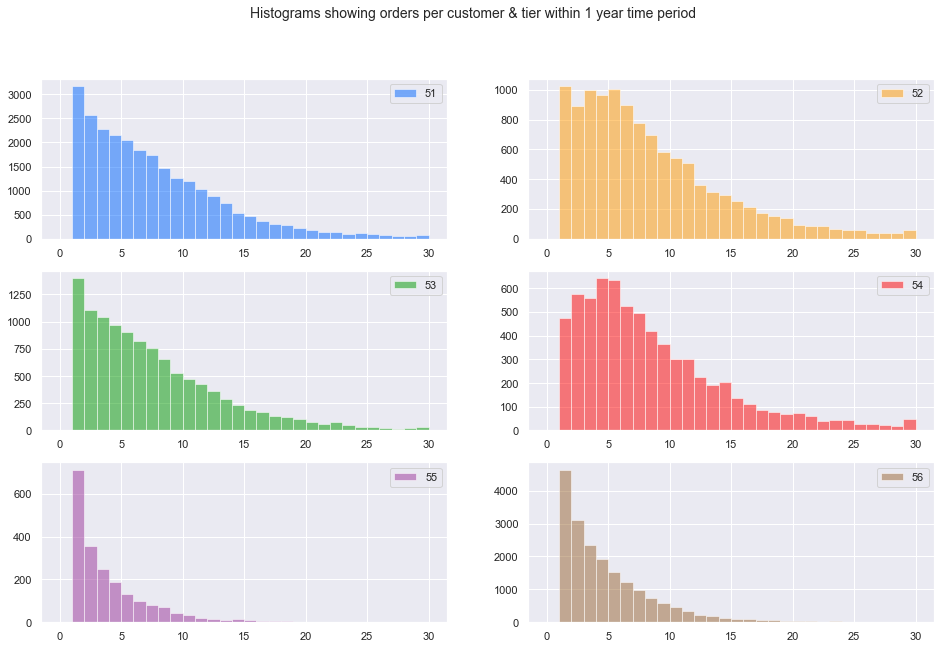

,Tier 51 ORDERS,Tier 52 ORDERS,Tier 53 ORDERS,Tier 54 ORDERS,Tier 55 ORDERS,Tier 56 ORDERS
count,26010.00,11708.00,11284.00,7071.00,2077.00,19132.00
mean,7.78,9.22,7.77,10.05,3.76,4.83
std,8.42,12.71,10.43,15.02,4.09,7.28
min,1.00,1.00,1.00,1.00,1.00,1.00
25%,3.00,4.00,3.00,4.00,1.00,2.00
50%,6.00,7.00,6.00,7.00,2.00,3.00
75%,10.00,11.00,10.00,12.00,5.00,6.00
max,243.00,517.00,426.00,375.00,82.00,276.00


In [38]:
sns.set()
plt.figure(figsize=(16,10))
plt.suptitle('Histograms showing orders per customer & tier within 1 year time period', fontsize=14)
plt.subplot(321)
data_tier_51 = t_customers[t_customers['CZP_ZTQ_ID_unique'] == 51]
data_tier_51['SCM_N_ORDER_NR_len'].hist(bins=30, range=(0, 30), color='#0066ff', alpha=0.5)
plt.legend([51])
plt.subplot(322)
data_tier_52 = t_customers[t_customers['CZP_ZTQ_ID_unique'] == 52]
data_tier_52['SCM_N_ORDER_NR_len'].hist(bins=30, range=(0, 30), color='#ff9900', alpha=0.5)
plt.legend([52])
plt.subplot(323)
data_tier_53 = t_customers[t_customers['CZP_ZTQ_ID_unique'] == 53]
data_tier_53['SCM_N_ORDER_NR_len'].hist(bins=30, range=(0, 30), color='#009900', alpha=0.5)
plt.legend([53])
plt.subplot(324)
data_tier_54 = t_customers[t_customers['CZP_ZTQ_ID_unique'] == 54]
data_tier_54['SCM_N_ORDER_NR_len'].hist(bins=30, range=(0, 30), color='#ff0000', alpha=0.5)
plt.legend([54])
plt.subplot(325)
data_tier_55 = t_customers[t_customers['CZP_ZTQ_ID_unique'] == 55]
data_tier_55['SCM_N_ORDER_NR_len'].hist(bins=30, range=(0, 30), color='#993399', alpha=0.5)
plt.legend([55])
plt.subplot(326)
data_tier_56 = t_customers[t_customers['CZP_ZTQ_ID_unique'] == 56]
data_tier_56['SCM_N_ORDER_NR_len'].hist(bins=30, range=(0, 30), color='#996633', alpha=0.5)
plt.legend([56])
plt.show() 

concat_df = pd.DataFrame()
for tq in ztq:
    data_tier = t_customers[t_customers['CZP_ZTQ_ID_unique'] == tq]
    concat_df = pd.concat([concat_df,
                           pd.DataFrame(data_tier['SCM_N_ORDER_NR_len'].describe().round(2)),
                           ], axis=1)
concat_df.columns = ['Tier 51 ORDERS', 'Tier 52 ORDERS', 'Tier 53 ORDERS',
                     'Tier 54 ORDERS', 'Tier 55 ORDERS', 'Tier 56 ORDERS']
display(concat_df)

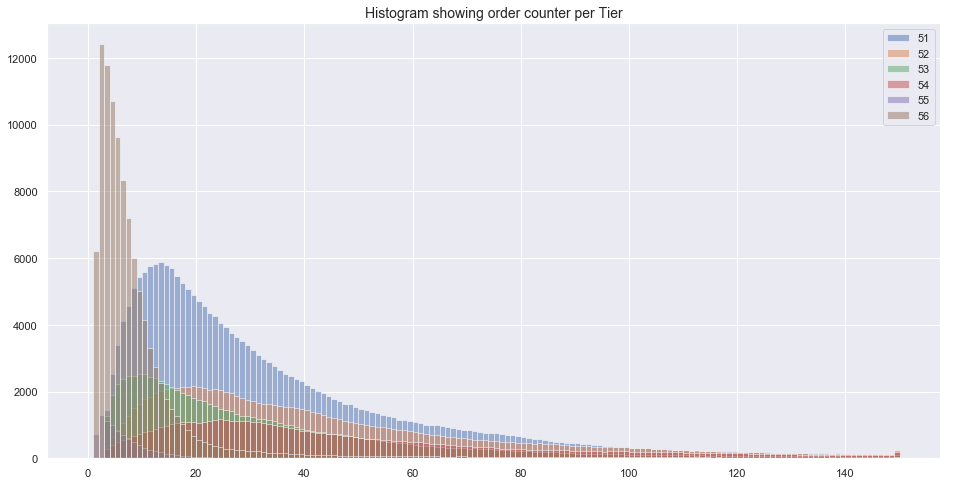

,Tier 51 Order_Counter,Tier 52 Order_Counter,Tier 53 Order_Counter,Tier 54 Order_Counter,Tier 55 Order_Counter,Tier 56 Order_Counter
count,225547.00,125710.00,93757.00,80004.00,9024.00,108305.00
mean,46.17,78.10,64.30,102.71,10.09,14.66
std,79.75,167.54,184.28,155.30,34.06,37.83
min,2.00,2.00,2.00,2.00,1.00,1.00
25%,15.00,21.00,13.00,25.00,3.00,3.00
50%,27.00,39.00,26.00,47.00,5.00,6.00
75%,50.00,74.00,50.00,104.00,9.00,10.00
max,1467.00,2318.00,2491.00,1597.00,384.00,839.00


In [39]:
concat_df = pd.DataFrame()
sns.set()
plt.figure(figsize=(16,8))
plt.title('Histogram showing order counter per Tier', fontsize=14)

for tq in ztq:
    data_tier = orders[orders['CZP_ZTQ_ID'] == tq]
    order_counter_values = [i for i in data_tier['OSP_KO_COUNT_NET'].values]
    plt.hist(order_counter_values, bins=150, range=(0, 150), alpha=0.5)
    plt.legend([51, 52, 53, 54, 55, 56])
    concat_df = pd.concat([concat_df,
                           (pd.DataFrame(order_counter_values).describe().round(2)),
                           ], axis=1)
plt.show() 

concat_df.columns = ['Tier 51 Order_Counter', 'Tier 52 Order_Counter', 'Tier 53 Order_Counter',
                     'Tier 54 Order_Counter', 'Tier 55 Order_Counter', 'Tier 56 Order_Counter']
display(concat_df)

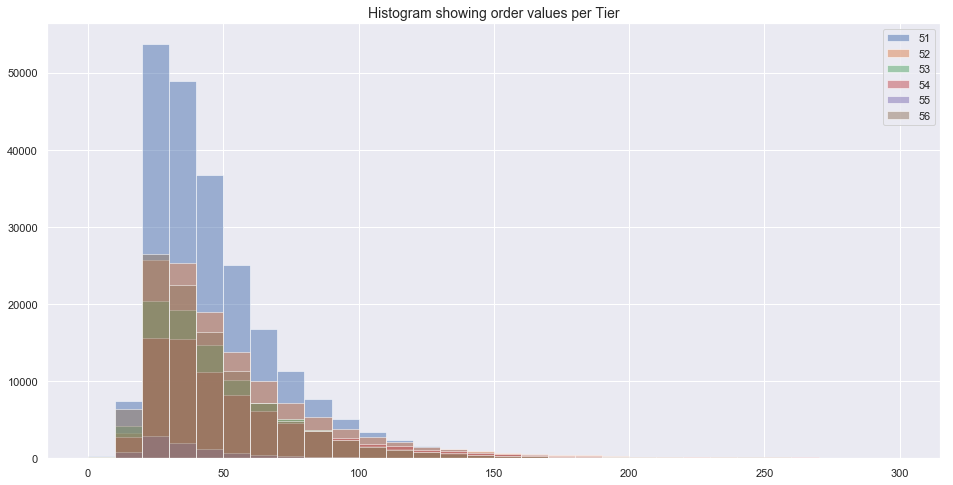

,Tier 51 Order_Values,Tier 52 Order_Values,Tier 53 Order_Values,Tier 54 Order_Values,Tier 55 Order_Values,Tier 56 Order_Values
count,225547.00,125710.00,93757.00,80004.00,9024.00,108305.00
mean,48.87,55.76,51.99,60.92,40.75,51.24
std,35.40,44.62,41.25,59.62,28.53,60.52
min,-7.12,-7.27,-6.38,-9.25,-0.91,-17.36
25%,29.06,30.83,29.40,30.94,24.39,27.62
50%,40.57,44.22,41.89,45.17,33.38,39.15
75%,58.58,66.89,61.97,71.24,47.55,57.84
max,4980.66,5352.81,3346.22,3201.43,494.43,3730.55


In [40]:
concat_df = pd.DataFrame()
sns.set()
plt.figure(figsize=(16,8))
plt.title('Histogram showing order values per Tier', fontsize=14)

for tq in ztq:
    data_tier = orders[orders['CZP_ZTQ_ID'] == tq]
    order_values = [i for i in data_tier['SCM_SALES_BMF'].values]
    plt.hist(order_values, bins=30, range=(0, 300), alpha=0.5)
    plt.legend([51, 52, 53, 54, 55, 56])
    concat_df = pd.concat([concat_df,
                           (pd.DataFrame(order_values).describe().round(2)),
                           ], axis=1)
plt.show() 

concat_df.columns = ['Tier 51 Order_Values', 'Tier 52 Order_Values', 'Tier 53 Order_Values',
                     'Tier 54 Order_Values', 'Tier 55 Order_Values', 'Tier 56 Order_Values']
display(concat_df)

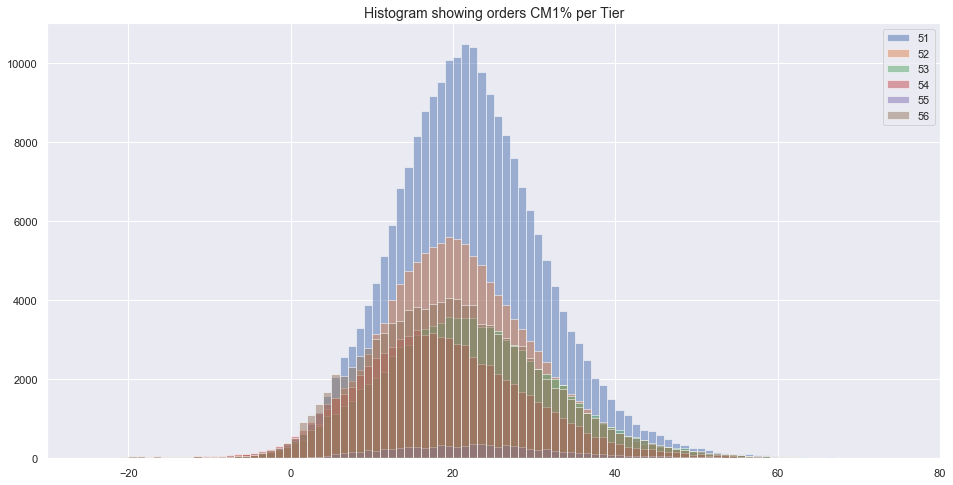

,Tier 51 Order_CM1%,Tier 52 Order_CM1%,Tier 53 Order_CM1%,Tier 54 Order_CM1%,Tier 55 Order_CM1%,Tier 56 Order_CM1%
count,225528.00,125697.00,93744.00,79998.00,9024.00,108298.00
25%,15.67,14.19,14.39,11.43,15.41,12.40
50%,21.56,20.19,21.37,17.99,22.70,19.59
75%,27.72,26.70,28.68,25.36,29.97,27.22


In [41]:
concat_df = pd.DataFrame()
sns.set()
plt.figure(figsize=(16,8))
plt.title('Histogram showing orders CM1% per Tier', fontsize=14)

for tq in ztq:
    data_tier = orders[orders['CZP_ZTQ_ID'] == tq]
    order_values_cm1 = [i for i in data_tier['SCM_D_FINANCE_CM1'].values]
    order_values_net_sales = [i for i in data_tier['SCM_D_ORIG_FINANCE_ORDER_NET'].values]
    orders_rel_cm1 = [i/j * 100 for i, j in list(zip(order_values_cm1, order_values_net_sales)) if j != 0]
    plt.hist(orders_rel_cm1, bins=100, range=(-25, 75), alpha=0.5)
    plt.legend([51, 52, 53, 54, 55, 56])
    concat_df = pd.concat([concat_df,
                           (pd.DataFrame(orders_rel_cm1).describe().round(2)),
                           ], axis=1)

plt.legend([51, 52, 53, 54, 55, 56])
plt.show() 

concat_df.columns = ['Tier 51 Order_CM1%', 'Tier 52 Order_CM1%', 'Tier 53 Order_CM1%',
                     'Tier 54 Order_CM1%', 'Tier 55 Order_CM1%', 'Tier 56 Order_CM1%']
display(concat_df.loc[['count', '25%', '50%', '75%']].astype(float))

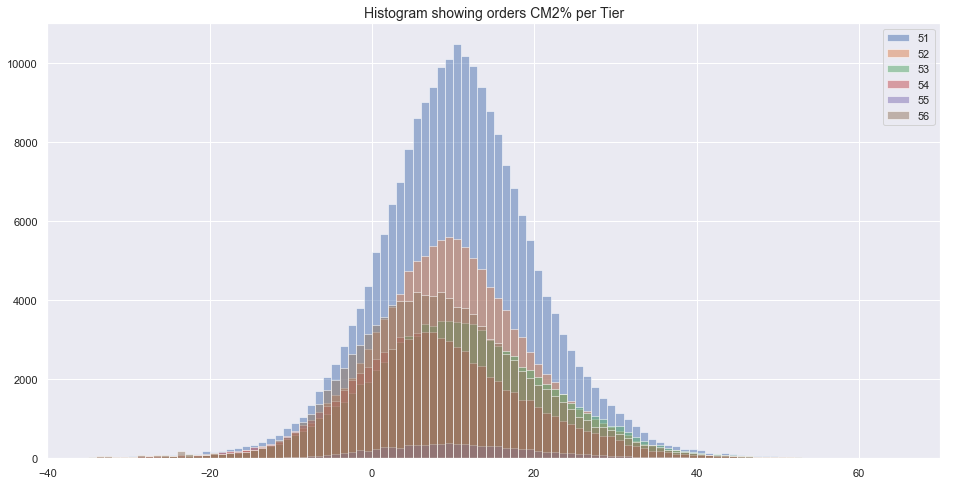

,Tier 51 Order_CM2%,Tier 52 Order_CM2%,Tier 53 Order_CM2%,Tier 54 Order_CM2%,Tier 55 Order_CM2%,Tier 56 Order_CM2%
count,225528.00,125697.00,93744.00,79998.00,9024.00,108298.00
25%,4.38,3.44,3.15,0.61,3.79,1.24
50%,10.45,9.60,10.32,7.35,10.23,8.03
75%,16.53,16.02,17.96,14.80,17.40,15.44


In [42]:
concat_df = pd.DataFrame()
sns.set()
plt.figure(figsize=(16,8))
plt.title('Histogram showing orders CM2% per Tier', fontsize=14)

for tq in ztq:
    data_tier = orders[orders['CZP_ZTQ_ID'] == tq]
    order_values_cm2 = [i for i in data_tier['SCM_D_FINANCE_CM2'].values]
    order_values_net_sales = [i for i in data_tier['SCM_D_ORIG_FINANCE_ORDER_NET'].values]
    orders_rel_cm2 = [i/j * 100 for i, j in list(zip(order_values_cm2, order_values_net_sales)) if j != 0]
    plt.hist(orders_rel_cm2, bins=100, range=(-35, 65), alpha=0.5)
    plt.legend([51, 52, 53, 54, 55, 56])
    concat_df = pd.concat([concat_df,
                           (pd.DataFrame(orders_rel_cm2).describe().round(2)),
                           ], axis=1)

plt.legend([51, 52, 53, 54, 55, 56])
plt.show() 

concat_df.columns = ['Tier 51 Order_CM2%', 'Tier 52 Order_CM2%', 'Tier 53 Order_CM2%',
                     'Tier 54 Order_CM2%', 'Tier 55 Order_CM2%', 'Tier 56 Order_CM2%']
display(concat_df.loc[['count', '25%', '50%', '75%']].astype(float))

In [43]:
metrics_ztq = pd.DataFrame(columns=['ZTQ','active_customers', 'orders', 'sales_bmf', 'net_sales', 'CM1', 'CM2', 'CM1%', 'CM2%',
                                   'discount_amount', 'orders_%_neg_cm1', 'loss_in_CM1', 'orders_%_neg_cm2', 'loss_in_CM2'])
for tq in ztq:
    df_elems = []
    data_tier = data[data['CZP_ZTQ_ID'] == tq]
    df_elems.append(tq)
    df_elems.append(data_tier['CUS_N_KEY_CUSTOMER'].nunique())
    df_elems.append(data_tier['SCM_N_ORDER_NR'].nunique())
    df_elems.append(data_tier['SCM_SALES_BMF'].sum())
    df_elems.append(data_tier['SCM_D_ORIG_FINANCE_ORDER_NET'].sum())
    df_elems.append(data_tier['SCM_D_FINANCE_CM1'].sum())
    df_elems.append(data_tier['SCM_D_FINANCE_CM2'].sum())
    df_elems.append(data_tier['SCM_D_FINANCE_CM1'].sum() / data_tier['SCM_D_ORIG_FINANCE_ORDER_NET'].sum() * 100)
    df_elems.append(data_tier['SCM_D_FINANCE_CM2'].sum() / data_tier['SCM_D_ORIG_FINANCE_ORDER_NET'].sum() * 100)
    df_elems.append((data_tier[data_tier['SCM_MASTER_AP_ID'] == 42715]['SCM_SALES_BMF']).sum())
    
    cm1_per_order = data_tier.groupby('SCM_N_ORDER_NR')['SCM_D_FINANCE_CM1'].sum()
    orders_neg_cm1 = cm1_per_order[cm1_per_order < 0].index.values
    df_elems.append(len(orders_neg_cm1)/data_tier['SCM_N_ORDER_NR'].nunique()*100)
    df_elems.append(cm1_per_order[cm1_per_order < 0].sum())
    
    cm2_per_order = data_tier.groupby('SCM_N_ORDER_NR')['SCM_D_FINANCE_CM2'].sum()
    orders_neg_cm2 = cm2_per_order[cm2_per_order < 0].index.values
    df_elems.append(len(orders_neg_cm2)/data_tier['SCM_N_ORDER_NR'].nunique()*100)
    df_elems.append(cm2_per_order[cm2_per_order < 0].sum())
    
    new_row = pd.DataFrame.from_records([df_elems], columns=metrics_ztq.columns)
    metrics_ztq = metrics_ztq.append(new_row, ignore_index=True)
    
display(metrics_ztq.round(2))

,ZTQ,active_customers,orders,sales_bmf,net_sales,CM1,CM2,CM1%,CM2%,discount_amount,orders_%_neg_cm1,loss_in_CM1,orders_%_neg_cm2,loss_in_CM2
0,51,30223,225547,11022611.63,10000344.12,2126330.60,1149880.19,21.26,11.50,-332050.46,0.92,-4710.96,12.94,-53926.88
1,52,14611,125710,7009501.78,6360650.56,1274572.81,698343.66,20.04,10.98,-213684.26,1.45,-5832.77,15.18,-40580.47
2,53,12402,93757,4874460.52,4418237.69,933724.84,524522.07,21.13,11.87,-252260.93,1.67,-3860.30,16.66,-33475.82
3,54,8094,80004,4873717.27,4428131.17,805564.44,417549.01,18.19,9.43,-255262.29,2.81,-6655.71,23.14,-45176.49
4,55,2336,9024,367709.72,333352.35,73674.03,38479.25,22.10,11.54,-7428.04,0.29,-49.54,13.63,-1657.74
5,56,22019,108305,5549213.44,5035128.25,935233.47,450858.64,18.57,8.95,-229869.94,1.86,-9117.10,21.10,-57540.50
